28    1725.0
32    2068.0
36    1661.0
40    1635.0
44    1952.0
48    1968.0
52    1599.0
Name: bandwidth(MiB/s), dtype: float64
0     770.0
4     779.0
8     785.0
12    760.0
16    769.0
20    760.0
24    745.0
Name: bandwidth(MiB/s), dtype: float64
       file_system           workloads  perf(MiBPS/OPS)  std-perf(MiBPS/OPS)
0      HUNTER-SYNC  gsf-filesrv-strict    286533.588722           410.545081
1      HUNTER-SYNC            fio-2048       779.000000            16.492423
2      HUNTER-SYNC            fio-4096       785.000000             7.000000
3      HUNTER-SYNC            fio-8192       760.000000             0.000000
4      HUNTER-SYNC           fio-16384       769.000000             0.000000
5      HUNTER-SYNC           fio-32768       760.000000             1.000000
6      HUNTER-SYNC           fio-65536       745.000000             4.000000
7      HUNTER-SYNC            fio-1024       770.000000             8.000000
8      HUNTER-SYNC        fileserver.f     58339.15000

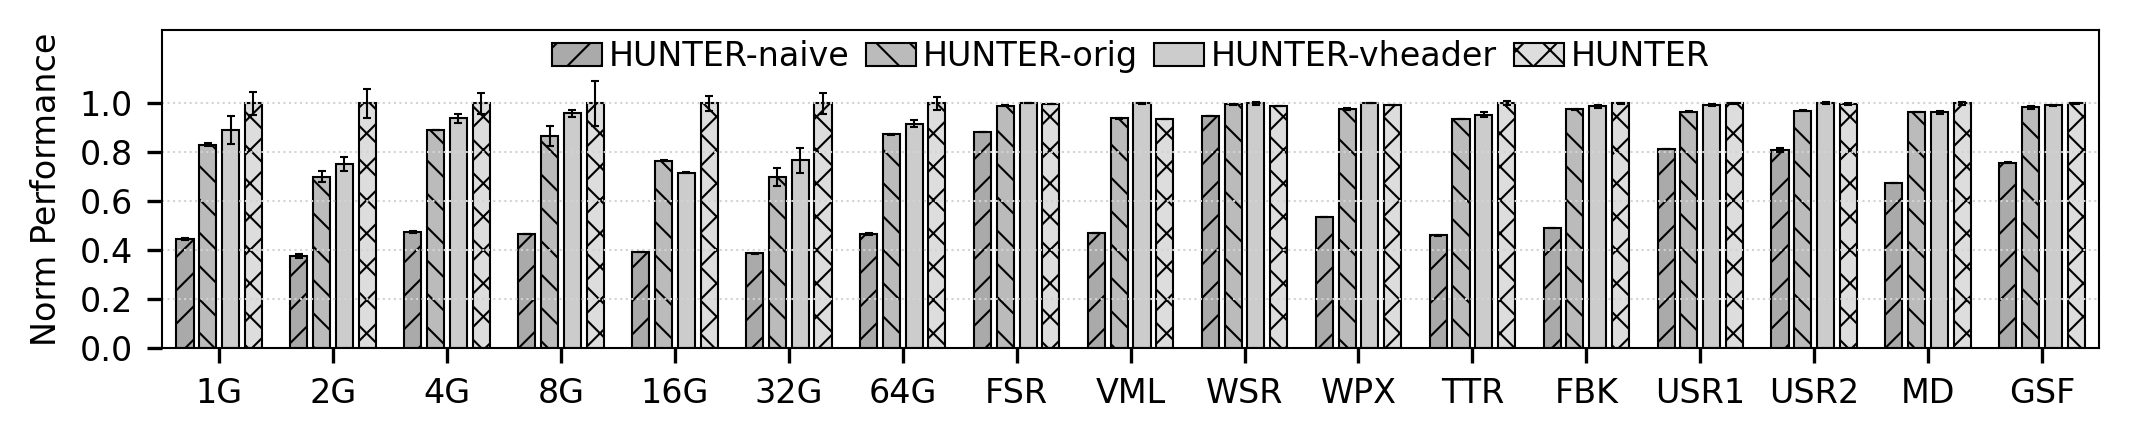

In [2]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

with open("../FIG-ST-MICRO/performance-comparison-table-fsync", "r") as f:
    df_fio = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

with open("../FIG-Filebench/performance-comparison-table", "r") as f:
    df_filebench = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

with open("../FIG-Trace/performance-comparison-table-fsync", "r") as f:
    df_trace = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

print(df_fio[(df_fio['file_system'] == "HUNTER-J") & (df_fio['ops'] == "seq-write")]['bandwidth(MiB/s)'])
print(df_fio[(df_fio['file_system'] == "HUNTER-SYNC") & (df_fio['ops'] == "seq-write")]['bandwidth(MiB/s)'])

def apply_df_fio(df, df_fio, fs):
    for i, fsize in enumerate([1024, 2048, 4096, 8192, 16384, 32768, 65536]):
        bw = df_fio[(df_fio['file_system'] == fs) & (df_fio['ops'] == "seq-write")]['bandwidth(MiB/s)'].iloc[i]
        file_system = fs
        workload = "fio-" + str(fsize)
        std_bw = df_fio[(df_fio['file_system'] == fs) & (df_fio['ops'] == "seq-write")]['std-bandwidth(MiB/s)'].iloc[i]
        new_row = pd.Series([file_system, workload, bw, std_bw], index=["file_system", "workloads", "perf(MiBPS/OPS)", "std-perf(MiBPS/OPS)"])
        df = df.append(new_row, ignore_index=True)
    return df

def apply_df_filebench(df, df_filebench, fs):
    for i, filebench in enumerate(["fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]):
        ops = df_filebench[(df_filebench['file_system'] == fs) & (df_filebench['file_bench'] == filebench) & (df_filebench['threads'] == 1)]['iops'].iloc[0]
        file_system = "HUNTER-SYNC" if fs == "HUNTER" else fs
        workload = filebench
        std_ops = 0
        new_row = pd.Series([file_system, workload, ops, std_ops], index=["file_system", "workloads", "perf(MiBPS/OPS)", "std-perf(MiBPS/OPS)"])
        df = df.append(new_row, ignore_index=True)
    return df

def apply_df_trace(df, df_trace, fs):
    for i, trace in enumerate(["twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv"]):
        ops = df_trace[(df_trace['file_system'] == fs) & (df_trace['trace'] == trace)]['ops'].iloc[0]
        file_system = fs
        workload = trace + "-strict"
        std_ops = df_trace[(df_trace['file_system'] == fs) & (df_trace['trace'] == trace)]['std-ops'].iloc[0]
        new_row = pd.Series([file_system, workload, ops, std_ops], index=["file_system", "workloads", "perf(MiBPS/OPS)", "std-perf(MiBPS/OPS)"])
        df = df.append(new_row, ignore_index=True)
    return df

df = apply_df_fio(df, df_fio, "HUNTER-J")
df = apply_df_fio(df, df_fio, "HUNTER-SYNC")
df = apply_df_filebench(df, df_filebench, "HUNTER-J")
df = apply_df_filebench(df, df_filebench, "HUNTER")
df = apply_df_trace(df, df_trace, "HUNTER-J")
df = apply_df_trace(df, df_trace, "HUNTER-SYNC")

sort_dict = {
    "HUNTER-J": 4,
    "HUNTER-vheader": 3,
    "HUNTER-orig": 2,
    "HUNTER-SYNC": 1
}
sort_df = pd.DataFrame(df['file_system'].map(sort_dict))
df = df.iloc[sort_df.sort_values(by = ["file_system"]).index]
df = df.reset_index().drop(columns=['index'])
print(df)

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(3.5)))
fig.patch.set_facecolor('white')
bar_width = 0.2
true_bar_width = 0.15
subfig_titles = ["(a) Non-strict trace replay", "(b) Strict trace replay"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = [ "#aaaaaa", "#bbbbbb", "#cccccc", "#dddddd", "#eeeeee", "#ffffff"]
cmap = "tab10"
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
workloads = [ "fio-1024", "fio-2048", "fio-4096", "fio-8192", "fio-16384", "fio-32768", "fio-65536", "fileserver.f", "varmail.f", "webserver.f", "webproxy.f", "twitter-strict", "facebook-strict", "usr1-strict", "usr2-strict", "moodle-strict", "gsf-filesrv-strict" ]
workloads_name_remap = [ "1G", "2G", "4G", "8G", "16G", "32G", "64G", "FSR", "VML", "WSR", "WPX", "TTR", "FBK", "USR1", "USR2", "MD", "GSF" ]

tot = len(fss) * bar_width
x = list(range(1, len(workloads) + 1))


for workload in workloads:
    value = df[(df['workloads'] == workload)]['perf(MiBPS/OPS)'] / df[(df['workloads'] == workload)]['perf(MiBPS/OPS)'].max()
    error = df[(df['workloads'] == workload)]['std-perf(MiBPS/OPS)'] / df[(df['workloads'] == workload)]['perf(MiBPS/OPS)'].max()
    df.loc[(df['workloads'] == workload), 'perf(MiBPS/OPS)'] = value
    df.loc[(df['workloads'] == workload), 'std-perf(MiBPS/OPS)'] = error

def add_explanation_and_title(fig, ax, exp, title, title_pad=10, title_fontsize=8, exp_fontsize=6):
    lable_pad = title_pad
    ax.set_xlabel(title, fontsize=title_fontsize, labelpad=lable_pad) 
    return [exp, title, title_pad, title_fontsize, exp_fontsize]
    
def adjust_explanation(fig, axes, context):
    exp, title, title_pad, title_fontsize, exp_fontsize = context
    
    # plt.tight_layout()
    # fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    # for ax in fig.axes:
        # plt.tight_layout()
        # Get the first xtick label
    midpoint = (0.5, 0.5)
    for idx, ax in enumerate(axes):
        xtick_label = ax.get_xticklabels()[0]
        label_bbox1 = xtick_label.get_window_extent()
        # print(label_bbox1)
        figure_pos1 = label_bbox1.transformed(ax.transAxes.inverted())
        
        # Get the xlabel object
        xlable = ax.xaxis.label
        label_bbox2 = xlable.get_window_extent()
        # print(label_bbox2)
        figure_pos2 = label_bbox2.transformed(ax.transAxes.inverted())
        midpoint = (0.5, (figure_pos1.y0 + figure_pos2.y1) / 2 + 0.08)
        
    print(midpoint)
    for idx, ax in enumerate(axes):
        explanation = ax.text(midpoint[0], midpoint[1], exp, ha='center', fontsize=exp_fontsize, transform=ax.transAxes)   

        # fig.savefig("./temp" + str(idx) + ".pdf", bbox_inches='tight', pad_inches=0)
        # # adjust midpoint
        # explanation_bbox = explanation.get_window_extent().transformed(ax.transAxes.inverted())
        # height = explanation_bbox.height
        # midpoint = (midpoint[0], midpoint[1] + height)
        # explanation.set_position(midpoint)

bars = []
for idx, fs in enumerate(fss):
    points = []
    for pivot in x:
        point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
        points.append(point)
    bws = []
    bws_error = []
    
    for workload in workloads:
        bws.append(df[(df['file_system'] == fs) & (df['workloads'] == workload)]['perf(MiBPS/OPS)'].iloc[0])
        bws_error.append(df[(df['file_system'] == fs) & (df['workloads'] == workload)]['std-perf(MiBPS/OPS)'].iloc[0])

    bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], color=colors[idx], edgecolor='black', linewidth=0.5)
    plt.errorbar(points, bws, yerr=bws_error, fmt='none', ecolor='black', elinewidth=0.5, capsize=1, capthick=0.5)
    # if fs == "HUNTER-J":
    # plt.scatter(points, [ bw + 0.05 for bw in bws], marker='*', color='red', s=5)
    
    # plt.bar(points, bws, width=bar_width, color='none', edgecolor='white', linewidth=0.5)
    bars.append(bar)
    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    
    # add_explanation_and_title(fig, subfig, "", subfig_titles[fig_idx], title_pad=0, title_fontsize=8, exp_fontsize=6)
    # Draw title
    print(x)
    print(workloads_name_remap)
    plt.xticks(x, labels=workloads_name_remap, fontsize=8)
    plt.xlim(0.5, 17.5)
    plt.ylim(0, 1.3)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
    plt.ylabel('Norm Performance', fontsize=8)
    # plt.xlabel(subfig_titles[fig_idx], fontsize=8)

fss.replace("SplitFS-FILEBENCH", "SplitFS", inplace=True)
fss.replace("HUNTER-SYNC", "HUNTER-naive", inplace=True)
fss.replace("HUNTER-J", "HUNTER", inplace=True)
legend_labels = fss

fig.legend(bars, legend_labels, loc='upper center', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, ncol=4, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5, labelspacing=0.1, borderpad=0.2)
# fig.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 0.9), ncol=1, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)

plt.tight_layout(pad=0.4)
plt.savefig("./FIG-SyncPerformance.pdf", bbox_inches='tight', pad_inches=0)
